# Projet data-science 2A
par Occitane Barbaux

https://www.youtube.com/watch?v=4tx-l9Gxlm0&feature=youtu.be

## Sommaire

1. Introduction
 * 1.1 Objectif
 * 1.2 Contexte
2. Exploration de la base 
 * 2.1 Bibliothèques et données
 * 2.2 Valeurs manquantes
 * 2.3 Exploration des corrélations
3. Préparation des données
 * 3.1 Transformation des variables catégorielles
 * 3.2 Ajout de variables
 * 3.3 Séparation des bases
4. Modélisation
 * 4.1 Validation croisée
 * 4.2 Random Forest
 * 4.3 Variables importantes
 * 4.4 KNN
 * 4.5 Choix de K
5. Comparaison
 * 5.1 Extraction des erreurs
 * 5.2 Faux positifs et faux négatifs
 * 5.3 Intersection des ensembles d'erreur
 * 5.4 Comparaison des deux modèles
6. Conclusion

    
## 1. Introduction

### 1.1 Objectif

Ce projet a pour but de prévoir si des individus gagnent plus de 50K par an. 

### 1.2 Contexte

La base utilisée est extraite de l'[US Adult Census de 1994](http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/). Elle comprend environ 49 000 observations.
Cette base a l'avantage de présenter une certaine diversité, avec des variables binaires, continues et catégorielles, ainsi que des valeurs manquantes.

Les données étant labellisées, puisque le Census nous permet de connaitre le niveau de revenu de l'individu, il s'agit d'un problème en apprentissage supervisé.

La sortie étant catégorielle (et binaire), il s'agit d'un problème de classification


## 2. Traitement de la base

Dans cette partie, nous allons réaliser trois étapes :
* Récupérer la base 
* Traiter les valeurs manquantes
* Explorer les données


### 2.1 Bibliothèques et données

Dans un premier temps, nous allons simplement importer les bibliothèques nécessaires à notre travail.

In [58]:
# Utilisations des données
import numpy as np
import pandas as pd

# Algorithmes de modélisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Aides à la modélisation
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configuration de la visualisation
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

Dans un second, nous allons transformer nos bases de travail en Dataframe.
On se réfère à la page de description de la base pour la liste des variables existantes.

Au passage, on supprime la premiere ligne de *test*, qui n'est pas valide.

In [59]:
columns = ['Age','Workclass','Sampling Weight','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']
train = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data", names=columns)
test    = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test", names=columns)

test = test.drop(test.index[0])

full = train.append( test , ignore_index = True )

print ('Datasets:' , 'full:' , full.shape , 'test:' , test.shape, 'train;', train.shape)

Datasets: full: (48842, 15) test: (16281, 15) train; (32561, 15)


In [60]:
test.head()

,Age,Workclass,Sampling Weight,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


### 2.2 Valeurs manquantes

On vérifie la proportion de valeurs manquantes.

In [2]:
full.Workclass.value_counts()

NameError: name 'full' is not defined

Dans cette base, les valeurs manquantes sont codées par un *?*.
Apres vérification, les variables *Occupation* et *Workclass* présentent un bon nombre de valeurs manquantes.

Cela représente seulement 3000 observations. On va donc **supprimer les données manquantes**.
On remarque que les populations n'ayant pas répondu sont quasiment les mêmes pour les deux questions.

In [65]:
for i in full.columns:
    full[i].replace(' ?', np.nan, inplace=True)
full.dropna()    
full.Workclass.value_counts()

 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: Workclass, dtype: int64

### 2.3 Exploration des corrélations

Notre base possède 15 variables. Il est temps d'explorer la base pour voir celles qui ont le plus d'influence sur le salaire. Pour cela, il est plus facile d'avoir déja la variable du salaire *Above/Below 50K* sous forme binaire.

On voit qu'environ 24% des individus de la base gagnent plus de 50K.

In [68]:
full['Above 50K'] = pd.Series( np.where( ((full['Above/Below 50K'] == ' >50K')|(full['Above/Below 50K'] == ' >50K.')) , 1 , 0 ) , name = 'Above 50K' )
full.describe()

,Sampling Weight,Education Num,Capital Gain,Capital Loss,Hours/Week,Above 50K
count,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,1.896641e+05,10.078089,1079.067626,87.502314,40.422382,0.239282
std,1.056040e+05,2.570973,7452.019058,403.004552,12.391444,0.426649
min,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.175505e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,1.781445e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,2.376420e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000



On commence par s'intéresser à la relation entre le **salaire et l'age**.
En effet, il parait difficile de gagner un haut revenu dès la fin des études. On s'attend donc à ce que la probabilité d'avoir un haut salaire croisse avec l'age.

La classe d'age étudiée va de 17 à 90ans.

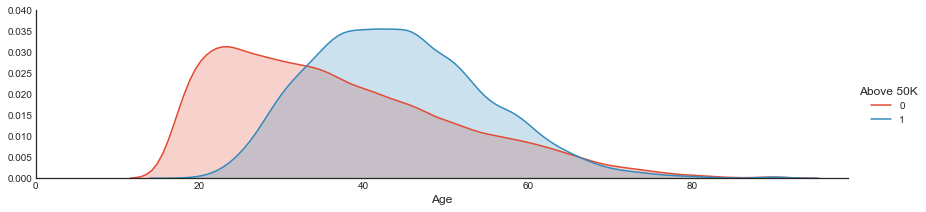

In [7]:
a = sns.FacetGrid( full, hue = 'Above 50K', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , 99), ylim=(0, 0.04))
a.add_legend()

On peut voir que les personnes agées d'entre **35 et 50 ans** sont sur représentées parmis celles gagnant un haut revenu.


On va maintenant observer l'effet du **sexe de l'individu**. Les femmes étant généralement sous représentées dans les professions à hauts salaires, on s'attend à un effet négatif lorsque l'individu est de sexe feminin.

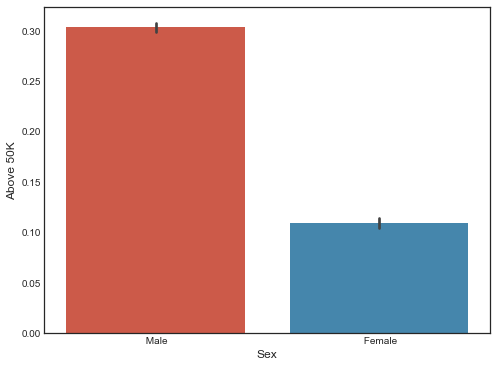

In [69]:
sns.barplot(x = 'Sex', y = 'Above 50K', data=full)

Effectivement, l'effet observé est conséquent: Seules **10% des femmes de la base gagnent plus de 50K, pour 30% des hommes**.

On se demande au passage si l'effet de l'age est le meme pour les deux sexes.

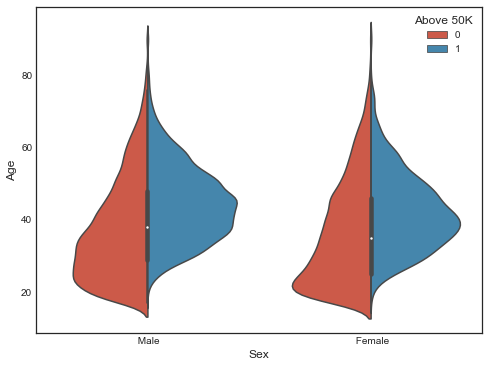

In [70]:
full.Age=pd.to_numeric(full.Age, downcast='float')
sns.violinplot(x = 'Sex', y = 'Age', hue = 'Above 50K', data = full, split =True)

L'age semble avoir **le même effet** pour les deux sexes.

On va maintenant s'intéresser au **type d'emploiement**. Il est possible pour un individu d'etre employé dans plusieurs types d'agences, notament publiques. Voyons si les différences ont une importance.

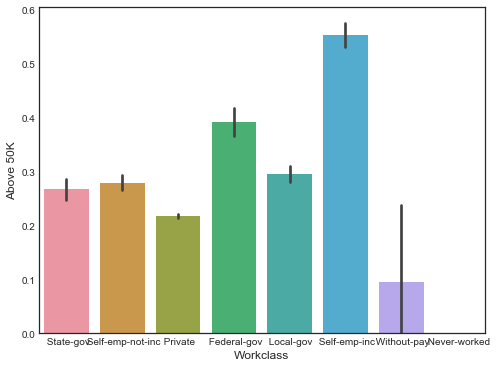

In [10]:
sns.barplot(x = 'Workclass', y = 'Above 50K', data=full)

Les différentes agences fédérales sont plutot **homogènes**, et peuvent donc corespondre à une catégorie unique.
Par contre, on observe une large différence entre les deux types de *self employement*. Il vaut donc mieux les laisser séparés.

On regarde aussi la répartition des revenus selon le **statut familial**.

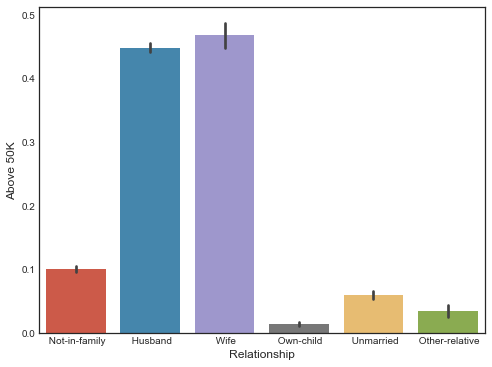

In [71]:
sns.barplot(x = 'Relationship', y = 'Above 50K', data=full)

Clairement, les individus **mariés** sont avantagés. 
Les parents célibataires aux contraires sont sous représentés.

On s'intéresse maintenant à la variable ***Race***

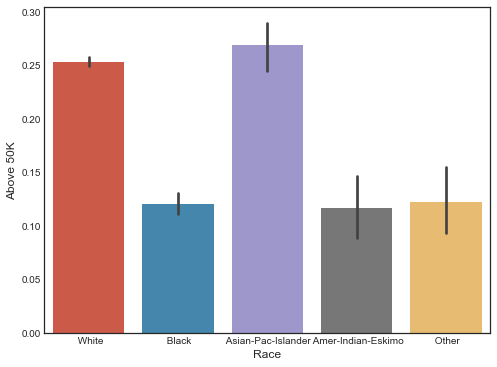

In [12]:
sns.barplot(x = 'Race', y = 'Above 50K', data=full)

Les personnes blanches ou d'origine asiatiques sont **sur représentées** par rapport aux autres catégories.

La variable ***Education*** devrait aussi avoir une forte influence. On s'attend à une proportion de hauts salaires croissante avec le nombre d'années d'études.

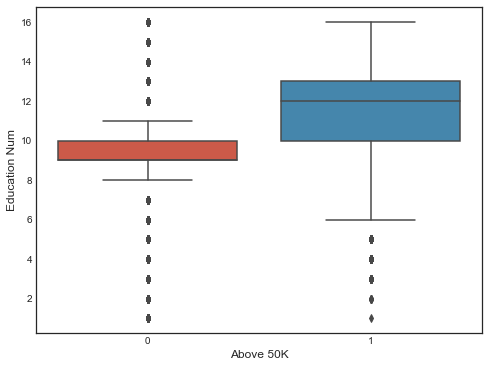

In [72]:
sns.boxplot(x ='Above 50K', y = 'Education Num', data = full)

Effectivement, le niveau d'étude est globalement plus haut pour le groupe des hauts salaires. Les études semblent inflencer le salaire à partir de 10 années.

On vérifie si c'est toujours valable avec une distinction par sexes.


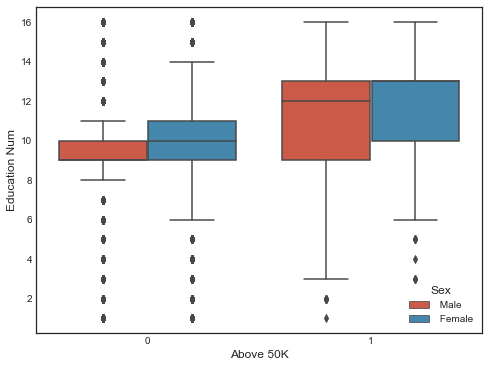

In [14]:
sns.boxplot(x ='Above 50K', y = 'Education Num',hue = 'Sex', data = full,)

Le niveau d'étude médian est plus haut pour les femmes (14ans au lieu de 12 pour les hommes). L'effet est donc légèrement différent.

## 3. Préparation des données

Dans cette partie nous allons :
* Transformer les variables catégorielles en *dummy variables*
* Ajouter les variables nécessaires
* Séparer la base en celle de test et celle d'entrainement 

### 3.1 Transformation des variables catégorielles

Nous allons ensuite nous interresser aux types de variables.
Il existe deux grands types de variables:
* Les variables **numériques**, contenant des nombres entiers ou réels, telles *Capital Gain* ou *Age*  
* Les variables **catégorielles**, qui contiennent un nombre limité et fixés de valeurs, comme ici le pays d'origine *Country*


In [15]:
full.head()

,Age,Workclass,Sampling Weight,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K,Above 50K
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,0
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0


Les variables *Workclass*, *Education*, etc sont des variables catégorielles. Certains modèles ne traitent que des variables numériques. Pour nous permettre de les utiliser nous devons créer des **dummy variables** pour chaque variable catégorielle.

Une **dummy variable** vaut 1 si l'individu possède une valeur fixée, et 0 sinon, et ce pour toutes les valeurs sauf une de la variable catégorielle.

*Sex*, tout comme *Above/Below 50K*, est une variable binaire.


In [73]:
Sex = pd.Series( np.where( ((full.Sex == ' Male')|(full.Sex =='Male')) , 1 , 0 ) , name = 'Sex' )

In [74]:
# Crée une nouvelle variable pour chaque valeur unique de Marital Status
maritalstatus = pd.get_dummies( full['Marital Status'] , prefix='Marital Status' )
maritalstatus.head()

,Marital Status_ Divorced,Marital Status_ Married-AF-spouse,Marital Status_ Married-civ-spouse,Marital Status_ Married-spouse-absent,Marital Status_ Never-married,Marital Status_ Separated,Marital Status_ Widowed
0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


On fait de même pour les autres variables catégorielles.

In [75]:
# Crée une nouvelle variable pour chaque valeur unique de Workclass
workclass = pd.get_dummies( full['Workclass'] , prefix='Workclass' )

# Crée une nouvelle variable pour chaque valeur unique de Occupation
occupation = pd.get_dummies( full['Occupation'] , prefix='Occupation' )

# Crée une nouvelle variable pour chaque valeur unique de Relationship
relationship = pd.get_dummies( full['Relationship'] , prefix='Relationship' )

# Crée une nouvelle variable pour chaque valeur unique de Race
race = pd.get_dummies( full['Race'] , prefix='Race' )

# Crée une nouvelle variable pour chaque valeur unique de Country
country = pd.get_dummies( full['Country'] , prefix='Country' )


In [76]:
occupation.head()

,Occupation_ Adm-clerical,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0



### 3.2 Ajout de variables

Certaines variables peuvent être simplifiées.
Ainsi, on donne une valeur 1 à *Maried* si l'individu est marié, et 0 sinon. 

La variable *Workclass* peut être simplifiée entre 'Gouv', 'Private', 'Self-emp-inc', 'Self-emp-not-inc' et 'Other' 
La variable *Race* peut être simplifiée entre 'White', 'Asian' et 'Other'.


In [77]:
full['Married']=relationship['Relationship_ Wife']+relationship['Relationship_ Husband']

full['Gouv']=workclass['Workclass_ Federal-gov']+workclass['Workclass_ Local-gov']+workclass['Workclass_ State-gov']
full['Private']=workclass['Workclass_ Private']
full['Self-emp-inc']=workclass['Workclass_ Self-emp-inc']
full['Self-emp-not-inc']=workclass['Workclass_ Self-emp-not-inc']

full['Race_W']=race['Race_ White']
full['Race_A']=race['Race_ Asian-Pac-Islander']


C'est aussi l'occasion de rajouter des variables utiles. Ainsi, la variable *Relationship* nous permet d'isoler les parents célibataires.

A partir de *Country*, on crée une variable *American* qui permet de savoir si l'individu est natif du pays.

In [78]:
full['Single_P']=relationship['Relationship_ Own-child']

full['American']=country['Country_ United-States']


On supprime maintenant les variables catégorielles ou redondantes

In [79]:
full=full.drop(['Workclass','Sampling Weight','Sex','Education', 'Marital Status','Occupation','Relationship','Race','Country','Above/Below 50K'], 1)


On ajoute les **Dummy variables** créées

In [80]:
full_T=pd.concat( [  Sex, full , occupation ] , axis=1 )
full_T.head()

,Sex,Age,Education Num,Capital Gain,Capital Loss,Hours/Week,Above 50K,Married,Gouv,Private,...,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving
0,1,39.0,13.0,2174.0,0.0,40.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,50.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,38.0,9.0,0.0,0.0,40.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,53.0,7.0,0.0,0.0,40.0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,28.0,13.0,0.0,0.0,40.0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


### 3.3 Séparation des bases 

Comme il est necessaire de comparer plusieurs modèles, nous allons séparer notre base en deux parties: 
* Une base *train* sur laquelle entrainer les modèles.
* Une base *test* qui permettra d'évaluer et donc de comparer les modèles. Cela permet aussi de repérer le problème en cas d'**overfitting** ou suraprentissage, c'est à dire lorsque le modèle se contente d'apprendre parfaitement les données


Pour cela, nous allons garder la répartition des bases fournies, où la base de test représentait environ un tier des individus.


In [81]:
Y=full_T['Above 50K'][:32000]
X= full_T.drop('Above 50K',1)[:32000]
X_test=full_T.drop('Above 50K',1)[32000:]
Y_test=full_T['Above 50K'][32000:]

print( Y.shape, X.shape, X_test.shape, Y_test.shape )

(32000,) (32000, 29) (16842, 29) (16842,)


## 4. Modélisation

Dans cette partie, nous allons :
* Définir la validation croisée
* Entrainer un modèle de Random Forest
* Trouver les variables importantes pour ce modèle
* Entrainer un modèle de KNN
* Trouver le K optimal

### 4.1 Validation croisée

Nous allons utiliser une *10-fold cross validation* pour estimer la fiabilité des modèles, c'est à dire que nous allons séparer notre base en 10, entrainer le modèle sur 9 et la tester sur le 10iem, et répéter cela pour toutes les combinaisons.

Nous allons utiliser l'option ‘accuracy‘ pour évaluer les modèles. C'est un ratio entre le nombre de bonne prédictions et le nombre total d'observations.

Un *seed* fixe permet de réaliser l'algorithme sur des données séparées de la meme manière. Cela nous permet d'avoir des resultats fixes. 

In [82]:
seed = 1

## 4.2 Random Forest

Le premier modèle que nous allons tester est un modèle de **forêt d'arbres décisionnels ou *Random Forest***. Il utilise des arbres de décisions.


In [83]:
rfc = RandomForestClassifier(n_estimators=100,random_state=seed)
rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [84]:
cvs1= cross_val_score(rfc, X, Y, cv = 10, scoring= 'accuracy')
print(cvs1.mean())

0.848875638684


**La fiabilité générale est plutôt bonne, à 84.8%, et bien plus haute qu'une répartition au hasard.**

Nous allons maintenant vérifier l'absence d'overfitting en testant la fiablité sur un ensemble de données inconnues au modèle.

In [47]:
print (rfc.score( X , Y ) , rfc.score( X_test , Y_test ))

0.973125 0.847820923881


Le score obtenu sur la base de test est très proche de celui obtenu par validation croisée. Le modele semble plutot robuste.

Nous allons maintenant regarder les erreurs du modèle.

In [85]:
Yrfc_predict = rfc.predict(X_test)
pd.DataFrame(
    confusion_matrix(Y_test, Yrfc_predict),
    columns=['Predicted <50K', 'Predicted >=50K'],
    index=['True <50K', 'True >=50K']
)

,Predicted <50K,Predicted >=50K
True <50K,11853,1010
True >=50K,1553,2426


In [86]:
print(classification_report(Y_test, Yrfc_predict))

             precision    recall  f1-score   support

          0       0.88      0.92      0.90     12863
          1       0.71      0.61      0.65      3979

avg / total       0.84      0.85      0.84     16842



**Visiblement, le modèle prédit bien mieux les bas salaires que les hauts.**

On note que le *recall* est plutot bas pour la catégorie des hauts salaires, ce qui signifie que la proportion de faux négatifs est conséquente.

### 4.3 Variables importantes

Nous allons maintenant voir quelles variables sont importantes pour ce modèle.



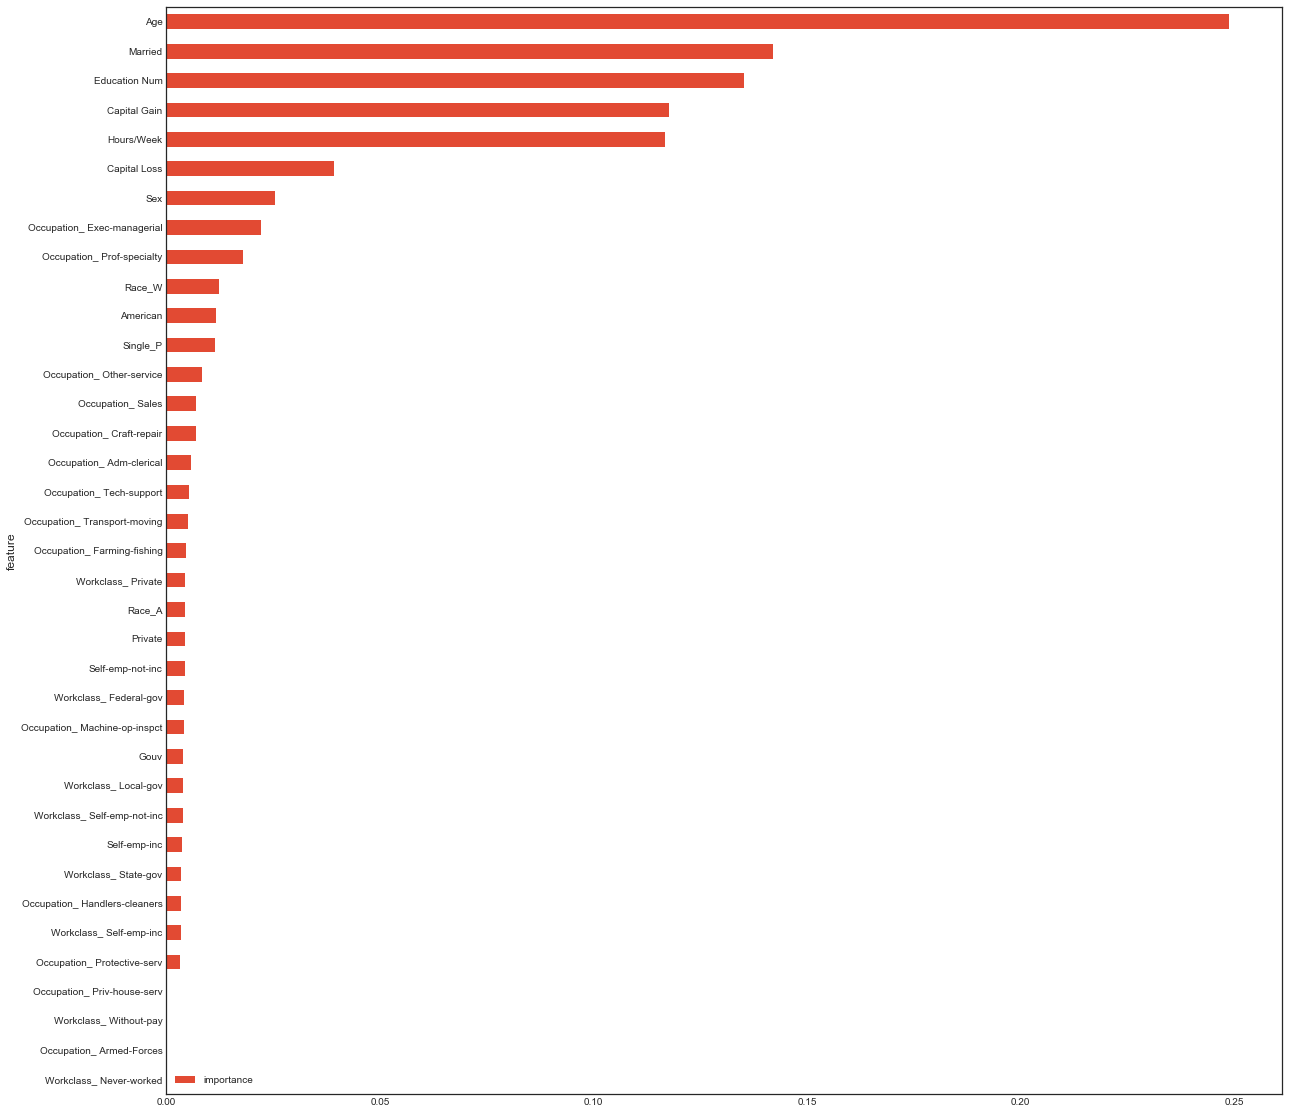

In [39]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = rfc.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(20, 20))

**L'*Age* a la plus forte importance.**
Mais contrairement à ce que j'attendais, le *Sexe* n'arrive qu'en 7iem position, et la *Race* encore plus loin. 

La variable *Maried* par contre, a une forte influence. 


### 4.4 KNN
 Le second modèle est une **Méthode des k plus proches voisins ou KNN**.
 
 Le K est ici fixé de façon optimale à 11. Le processus pour l'obtenir, basé sur la validation croisée, est réalisé dans la partie suivante.
 
On entraine tout d'abord le modèle.

In [93]:
knc =  KNeighborsClassifier(n_neighbors=11)
knc.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

Par validation croisée, on obtient un premier score de fiabilité.

In [94]:
cvs2= cross_val_score(knc, X, Y, cv = 10, scoring= 'accuracy')
print(cvs2.mean())

0.849250570108


**La fiabilité générale est plutôt bonne, à 85%, légèrement supérieure à la Random Forest.**

Nous allons maintenant vérifier l'absence d'overfitting en testant la fiablité sur un ensemble de données inconnues au modèle.

In [95]:
print (knc.score( X , Y ) , knc.score( X_test , Y_test ))

0.87421875 0.851680323002


Le score obtenu sur la base de test est très proche de celui obtenu par validation croisée. Le modèle semble plutot robuste.

Nous allons maintenant regarder les erreurs du modèle.

On isole tout d'abord les prédictions du modèle sur la base de test, et l'on s'en sert pour créer une matrice de confusion.

In [96]:
Yknc_predict = knc.predict(X_test)
pd.DataFrame(
    confusion_matrix(Y_test, Yknc_predict),
    columns=['Predicted <50K', 'Predicted >=50K'],
    index=['True <50K', 'True >=50K']
)

,Predicted <50K,Predicted >=50K
True <50K,11944,919
True >=50K,1579,2400


In [97]:
print(classification_report(Y_test, Yknc_predict))

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     12863
          1       0.72      0.60      0.66      3979

avg / total       0.85      0.85      0.85     16842



Ce modèle aussi prédit bien mieux les bas salaires que les hauts.

### 4.5 Choix de K

Pour optimiser le choix de K, nous allons utiliser la validation croisée.

Ici, le score utilisé est la **fiabilité**. Le choix d'un autre score comme le F1 ou le recall donnera un K optimal différent.

Attention, due à la taille conséquente de la base, le processus prend plusieurs minutes.

In [89]:
myList = list(range(1,50))

# on ne garde que les impaires
neighbors = [x for x in myList if x % 2 != 0]
cv_scores = []

# on utilise la validation croisée pour obtenir la fiabilité
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
    #scores = cross_val_score(knn, X, Y, cv=10, scoring='recall')
    #scores = cross_val_score(knn, X, Y, cv=10, scoring='f1')
    cv_scores.append(scores.mean())
    

On extrait ensuite l'erreur de classification, que l'on souhaite minimiser.

In [90]:
# Erreur de classification
MSE = [1 - x for x in cv_scores]
print(MSE)

[0.18534334711910128, 0.16199932277215068, 0.15506179322197688, 0.15287448847956431, 0.15181200798029848, 0.15074942989191198, 0.15153067006219911, 0.151374263812184, 0.15240544548637158, 0.15128046502372694, 0.151686666186442, 0.15184297473747321, 0.15137423446952969, 0.15128065050653328, 0.15096799426262153, 0.15115553328240061, 0.1517807188689666, 0.15228087516781008, 0.15334330677485908, 0.15278094348751892, 0.15399951778559751, 0.15390579703059548, 0.15437466426083135, 0.15443724237363199, 0.15446847289120824]


On détermine le k optimal

In [91]:

optimal_k = neighbors[MSE.index(min(MSE))]

print("Le nombre de voisins optimal est %d" % optimal_k)


Le nombre de voisins optimal est 11


On représente l'erreur de classification suivant K

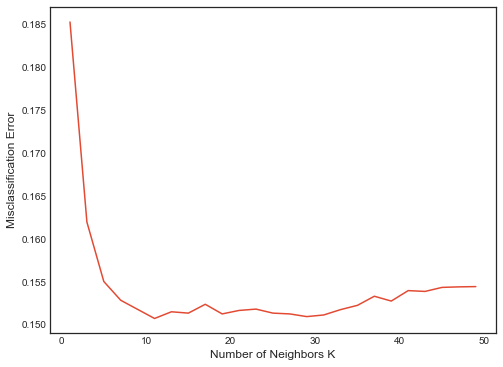

In [92]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

On obtient **K = 11** , la valeur choisie au paragraphe précédent.

## 5 Comparaisons

Dans cette partie, nous allons :
* Extraire les individus victimes d'erreurs sur chaque modèle
* Comparer les individus faux positifs et faux négatifs pour chaque modèle
* Chercher si les fausses prédictions sont les mêmes pour chaque modèle
* Comparer globalement les deux modèles

### 5.1 Extractions des erreurs

On extrait les erreurs du modèle Random Forest en séparant faux positifs et faux négatifs.

In [98]:
X_test['Miss_rfc_fp']= (Yrfc_predict - Y_test ==1)
X_test['Miss_rfc_fn']= (Y_test-Yrfc_predict == 1)

On extrait les erreurs du modèle KNN en séparant faux positifs et faux négatifs.

In [99]:
X_test['Miss_knc_fp']= (Yknc_predict - Y_test ==1)
X_test['Miss_knc_fn']= (Y_test-Yknc_predict == 1)

### 5.2 Faux positifs et faux négatifs

On sépare les faux négatifs du Random Forest selon l'age et le statut marital.

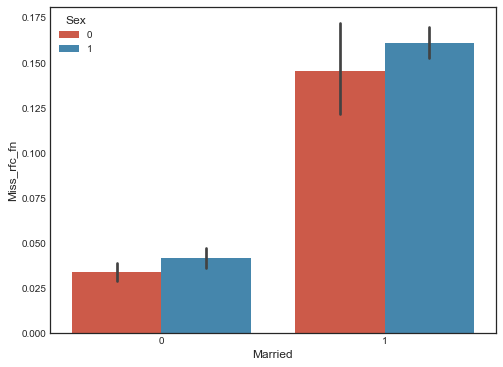

In [100]:
sns.barplot(x = 'Married', y = 'Miss_rfc_fn', hue = 'Sex', data=X_test)

On fait de même avec les faux négatifs du KNN

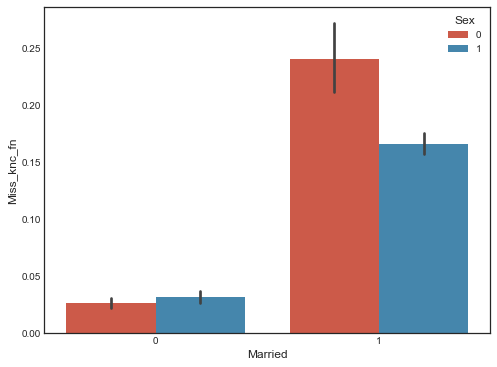

In [101]:
sns.barplot(x = 'Married', y = 'Miss_knc_fn', hue = 'Sex', data=X_test)

On note que les personnes mariées sont beaucoup plus touchées par l'erreur que les autres pour les deux modèles. La répartition selon les sexes diffère cependant pour chaque modèle.

On fait de même pour les faux positifs.

On commence par les faux positifs du Random Forest

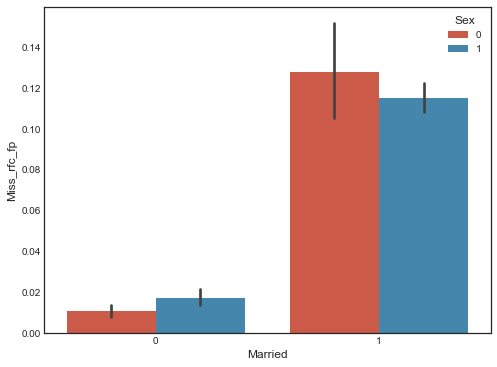

In [102]:
sns.barplot(x = 'Married', y = 'Miss_rfc_fp', hue = 'Sex', data=X_test)

Puis les faux positifs du KNN

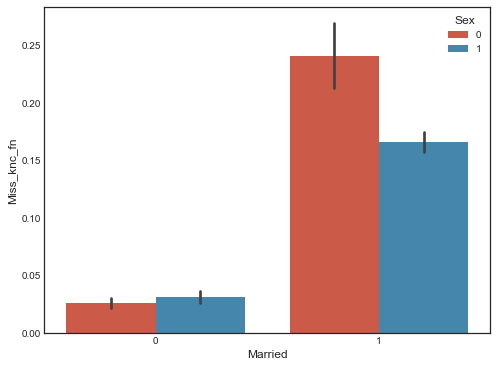

In [103]:
sns.barplot(x = 'Married', y = 'Miss_knc_fn', hue = 'Sex', data=X_test)

Les gens mariés ont beaucoup de faux positifs et de faux négatifs. Il doit donc y avoir une variable qui impacte principalement les gens mariés. 

Apres une recherche parmis toutes les autres variables, seule celle permettant de distinguer les parents célibataires apporte une précision reservée aux gens non mariés.Cependant, elle est minime. On peut supposer qu'une **variable manquante**, comme le fait d'avoir des enfants, entraine cette imprécisions supérieure pour les individus mariés.

### 5.3 Intersection des ensembles d'erreurs

On cherche à savoir si les fausses prédictions sont les mêmes pour les deux modèles

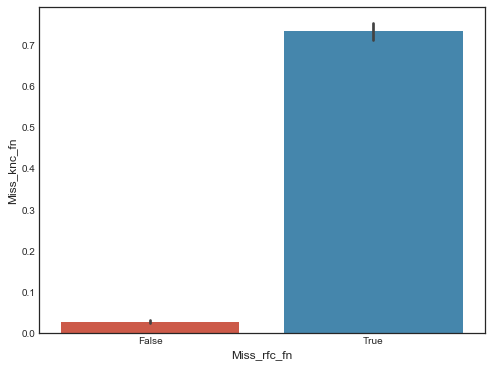

In [104]:
sns.barplot(x = 'Miss_rfc_fn', y = 'Miss_knc_fn', data=X_test)

Effectivement, les faux négatifs sont principalement les mêmes.

On fait de même pour les faux positifs.

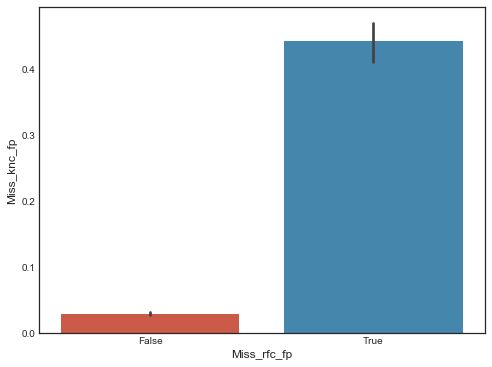

In [105]:
sns.barplot(x = 'Miss_rfc_fp', y = 'Miss_knc_fp', data=X_test)

Ici, il y a substantiellement moins de faux positifs en commun. C'est probablement du au fait que le KNN a un taux de recall plus haut pour les personnes au salaire inférieur à 50K. Etant donné que cela représente une grosse majorité des individus (Environ 75%), le nombre de faux positifs est très différent.

### 5.4 Comparaison des deux modèles

Les deux modèles ont une **fiabilité plutot haute (proche de 85%)**. Cependant, leur recall les différencie.

En effet, avec le **Random Forest**, le niveau de recall pour les personnes gagnant plus de 50K est un peu plus haut (61% pour 60% avec le KNN). Cet algorithme est celui que l'on choisira si notre but est d'**éviter les faux négatifs**, par exemple pour une entreprise de publicité qui ne souhaite pas manquer des profils intéressants.

Au contraire, le **KNN** possède un niveau de recall légèrement supérieur pour les personnes au salaire inférieur à 50K. Au vu de la taille de la base de test, la différence de 1% n'est pas négligeable puisqu'elle concerne environ 150 individus. Cet algorithme est celui que l'on choisira si notre but est d'**éviter les faux positifs**, par exemple pour une entreprise d'évaluation des candidats qui ne souhaite pas gaspiller ses ressources.

Les algorithmes diffèrent selon d'autres aspects:


Le KNN est coûteux en **puissance de calculs**, et le choix de son hyperparamètre **prend du temps**, pour un gain de précision limité. Ce n'est pas l'agorithme le plus efficace, surtout au vu de la taille de la base.

Le random Forest est plus rapide, mais le **risque d'overfitting** est grand, surtout si l'on ne sélectionne pas les variables au préalable.


## 6. Conclusion


Au vu du niveau de *recall* pour les deux catégories, le modele n'est pas vraiment exploitable pour eviter les faux négatifs.
Par contre, si la problématique posée est celle d'éviter les faux positifs, alors nos modeles sont acceptables.

Dans ce cas, on se retrouve avec un arbitrage entre fiabilité et rapidité:
* Si il s'agit d'une étude marketing souvent mise à à jour, comme pour une campagne publicitaire, il peut être préférable de sacrifier un peu de précision en utilisant le Random Forest, qui travaille bien plus rapidement.
* Au contraire, si notre étude est une recherche sociologique dont les bases ne sont mises à jour qu'annuellement, voir moins que cela, le gain de précision de KNN pourra être favorisé.